Using pdf from Matt:
```
@article{Alberty1998Jun,
	author = {Alberty, Jochen and Carstensen, Carsten and Funken, Stefan A.},
	title = {{Remarks Around 50 Lines Of Matlab: Short Finite Element Implementation}},
	journal = {Numerical Algorithms},
	volume = {20},
	number = {2-3},
	year = {1998},
	month = {Jun},
	issn = {1017-1398},
	doi = {10.1023/A:1019155918070}
}
```

And tutorial <https://www.particleincell.com/2012/matlab-fem/>

And intro to finite elements <http://arturo.imati.cnr.it/~marini/didattica/Metodi-engl/Intro2FEM.pdf>

In [1]:
from mesh2d import Mesh2D as Mesh
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
import math
%matplotlib inline

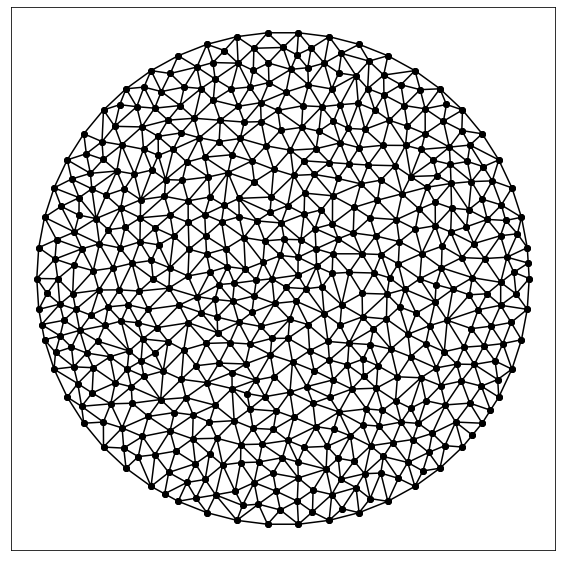

In [2]:
# Create mesh
mesh = Mesh(50, min_size=0.005, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Heat Equation (Dirichlet)

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u + f$
- body force: $f(x,y) = 4$
- Dirichlet boundary: $u_{boundary} = 0$
- Initial state: $u=0$

Error is 0.03666002241578769


Text(0.5, 1.0, 'Solution')

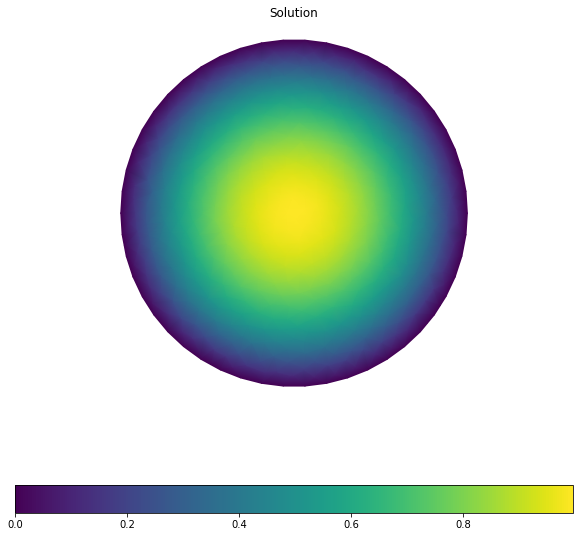

In [3]:
def calculate_body_force(vertex):
    # Body force is simply f=4
    return 4

dt = 0.1
T = 10.0
t = 0.0

# Initial conditions
u_prev = np.zeros(mesh.n_vertices)

# Assemble matrices & body force
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()
force_vector = mesh.assemble_body_force(calculate_body_force)

# Apply boundary conditions
stiffness[mesh.boundary_vertices,:] = 0.0
stiffness[:,mesh.boundary_vertices] = 0.0
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0
force_vector[mesh.boundary_vertices] = 0.0

# Solve
lhs_matrix = dt*stiffness + mass

while t<T:
    rhs_vector = dt*force_vector + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    t+=dt

soln = u_next

# Calculate error
error = [
    abs(soln[i] - (1.0 - vertex[0]**2 - vertex[1]**2))
    for i, vertex in enumerate(mesh.vertices())]

print("Error is", np.linalg.norm(error))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, axis=ax)
ax.set_title('Solution')

# Heat Equation (zero von Neumann)

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u$
- von Neumann boundary: $\partial u_{boundary} = 0$
- Initial state: $u=0$

Error is 0.031700447737269356


Text(0.5, 1.0, 'Final')

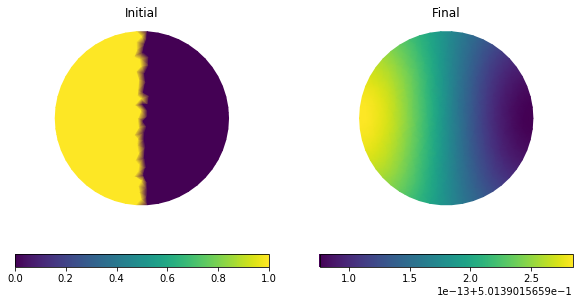

In [4]:
def calculate_initial_condition(vertex):
    if vertex[0] < 0.0:
        return 1.0
    else:
        return 0.0

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

dt = 0.1
T = 10.0
t = 0.0

# Initial conditions
u0 = set_initial_conditions(mesh)
u_prev = set_initial_conditions(mesh)

# Assemble matrices
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()

# Solve
lhs_matrix = dt*stiffness + mass

while t<T:
    rhs_vector = mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    t+=dt

soln = u_next

# Calculate error
error = [
    abs(soln[i] - 0.5)
    for i, vertex in enumerate(mesh.vertices())]

print("Error is", np.linalg.norm(error))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
mesh.plot(u0, axis=axes[0])
axes[0].set_title('Initial')
mesh.plot(soln, axis=axes[1])
axes[1].set_title(r'Final')

# Heat Equation (non-zero von Neumann)

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u$
- von Neumann boundary: $\partial u_{boundary} = 1$
- Initial state: $u=0$

Error is 0.029600367314815575


Text(0.5, 1.0, 'Analytical Solution')

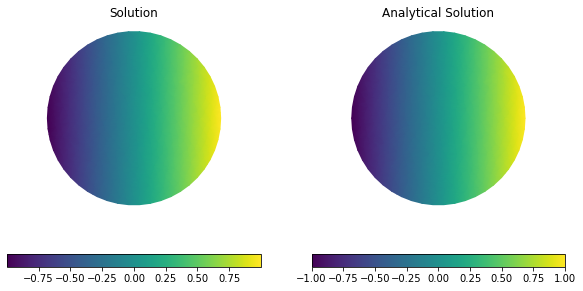

In [5]:
def calculate_initial_condition(vertex):
    return 0.0

def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

def calculate_boundary_value(vertex):
#     return 1
    return math.cos(theta_from_vertex(vertex))

def generate_boundary_values(mesh):
    boundary_values = np.zeros(mesh.n_vertices)
    values = list(map(lambda index: calculate_boundary_value(mesh.get_pos(index)), mesh.boundary_vertices))
    boundary_values[mesh.boundary_vertices] = values
    return boundary_values

def analytical_solution(vertex):
    return vertex[0]

dt = 0.1
T = 20.0
t = 0.0

# Initial conditions
u0 = set_initial_conditions(mesh)
u_prev = set_initial_conditions(mesh)

# Assemble matrices
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()
force_vector = np.zeros(mesh.n_vertices)

boundary_values = generate_boundary_values(mesh)
boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

# Solve
lhs_matrix = dt*stiffness + mass

while t<T:
    rhs_vector = dt*(force_vector + boundary_vector) + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    t+=dt

soln = u_next

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex))
    for i, vertex in enumerate(mesh.vertices())]

analytical_solution = [analytical_solution(vertex) for vertex in mesh.vertices()]

print("Error is", np.linalg.norm(error))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,5))
mesh.plot(soln, axis=axes[0])
axes[0].set_title('Solution')
mesh.plot(analytical_solution, axis=axes[1])
axes[1].set_title(r'Analytical Solution')